In [15]:
import numpy as np
import pandas as pd
import os


In [16]:
import random
from PIL import Image, ImageDraw
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



In [17]:
import torch
torch.cuda.empty_cache()
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [18]:
train = pd.read_csv(r'C:\Users\vtshu\Documents\scripts\internship\input\IC detection.v1i.tensorflow\train\_annotations.csv')

In [19]:
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,15_jpg.rf.ecd57f30f08ec0d3270986ba79f5acb0.jpg,640,640,dog,155,154,477,475
1,91_jpg.rf.f23de3c8481e492cd74e7d1b664abf6c.jpg,640,640,dog,101,43,583,552
2,76_jpg.rf.f2964a1e19fa67852c1363c44505dbc6.jpg,640,640,dog,31,10,626,541
3,pcb76_jpg.rf.f75a5e48c7b3096efe80c2fd901fc68d.jpg,640,640,dog,517,168,615,404
4,pcb76_jpg.rf.f75a5e48c7b3096efe80c2fd901fc68d.jpg,640,640,dog,85,117,122,225


In [28]:
train.drop(["width","height","class"],axis = 1,inplace = True)

In [29]:
df = train

In [30]:
df.head()

,filename,xmin,ymin,xmax,ymax
0,15_jpg.rf.ecd57f30f08ec0d3270986ba79f5acb0.jpg,155,154,477,475
1,91_jpg.rf.f23de3c8481e492cd74e7d1b664abf6c.jpg,101,43,583,552
2,76_jpg.rf.f2964a1e19fa67852c1363c44505dbc6.jpg,31,10,626,541
3,pcb76_jpg.rf.f75a5e48c7b3096efe80c2fd901fc68d.jpg,517,168,615,404
4,pcb76_jpg.rf.f75a5e48c7b3096efe80c2fd901fc68d.jpg,85,117,122,225


In [33]:
unique_imgs = df.filename.unique()

In [34]:
unique_imgs

array(['15_jpg.rf.ecd57f30f08ec0d3270986ba79f5acb0.jpg',
       '91_jpg.rf.f23de3c8481e492cd74e7d1b664abf6c.jpg',
       '76_jpg.rf.f2964a1e19fa67852c1363c44505dbc6.jpg',
       'pcb76_jpg.rf.f75a5e48c7b3096efe80c2fd901fc68d.jpg',
       's14_front2_png_jpg.rf.ec93abd681344759ef77c4c1c5c2b73e.jpg',
       'pcb128_jpg.rf.ed0a8f5b661627222f7737d69050222a.jpg',
       'pcb6_jpg.rf.edd56f154fb62347d321d00bdb93eaaf.jpg',
       's3_back_png_jpg.rf.ee4ee1bccd7b2df66154393afd40eb87.jpg',
       'ML450_Top2_jpg.rf.f05348432265c39f16c681a2d6f35bc5.jpg',
       's11_front1_png_jpg.rf.f14cae2ad513685c51c7e8a64e6e9f76.jpg',
       'pcb75_jpg.rf.f1a91fe72959346314c00bfa64db68fb.jpg',
       's8_front_png_jpg.rf.f400c99830ea0c3361161d88734ac36c.jpg',
       'pcb10_jpg.rf.f432cf54c0791cb078b081add4af417d.jpg',
       'pcb107_jpg.rf.f2f1a9ec12831eadb8b20c9ca58feaf0.jpg',
       'Zybo_jpg.rf.f701f8e030ee3ef72adc4a84cd2c703c.jpg',
       'pcb107_jpg.rf.f72dba5cba97fa17b06fe19233c68fb2.jpg',
       's2_b

In [44]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self,df,unique_imgs,indices):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self,idx):
        image_name = self.unique_imgs[self.indices[idx]]
        boxes = self.df[self.df.filename == image_name].values[:,1:].astype("float") 
        img = Image.open("C:/Users/vtshu/Documents/scripts/internship/input/IC detection.v1i.tensorflow/train/"+image_name).convert('RGB')
        labels = torch.ones((boxes.shape[0]) , dtype = torch.int64)
        target = {}
        target["boxes"] = torch.tensor(boxes)
        target["label"] = labels
        return T.ToTensor()(img) , target

In [45]:
train_inds, val_inds = train_test_split(range(unique_imgs.shape[0]),test_size = 0.1)

In [87]:
len(train_inds)

482

In [46]:
def custom_collate(data):
    return data

In [47]:
train_dl = torch.utils.data.DataLoader(CustDat(df , unique_imgs, train_inds),
                                      batch_size = 16,
                                      shuffle = True,
                                      collate_fn = custom_collate,
                                      pin_memory = True if torch.cuda.is_available() else False)

val_dl = torch.utils.data.DataLoader(CustDat(df , unique_imgs, val_inds),
                                      batch_size = 16,
                                      shuffle = True,
                                      collate_fn = custom_collate,
                                      pin_memory = True if torch.cuda.is_available() else False)

In [48]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [49]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [50]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
torch.cuda.empty_cache()

In [51]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum= 0.9, weight_decay=0.0005)
num_epochs = 5

In [52]:
model.to(device)
for epochs in range(num_epochs):
    epoch_loss = 0
    for data in train_dl:
        imgs = []
        targets = []
        for d in data:
            imgs.append(d[0].to(device))
            targ = {}
            targ["boxes"] = d[1]["boxes"].to(device)
            targ["labels"] = d[1]["label"].to(device)
            targets.append(targ)
        loss_dict = model(imgs, targets)
        loss = sum(v for v in loss_dict.values())
        epoch_loss += loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(epoch_loss)
        
    

50.10745185505541
31.48030185638883
27.59466259119267
25.75209201791473
24.23924148181428


In [53]:
model.eval()
data = iter(val_dl).__next__()

In [77]:
len(data)

8

In [88]:
img = data[7][0]
boxes = data[7][1]["boxes"]
labels = data[7][1]["label"]

In [89]:
output = model([img.to(device)])

In [90]:
out_bbox = output[0]["boxes"]
out_scores = output[0]["scores"]

In [91]:
keep = torchvision.ops.nms(out_bbox,out_scores, 0.45)

In [92]:
out_bbox.shape, keep.shape

(torch.Size([61, 4]), torch.Size([54]))

In [93]:
im = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')

In [94]:
im

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [4, 4, 4],
        [0, 0, 0],
        [2, 2, 2]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [6, 6, 6],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [8, 8, 8],
        [0, 0, 0],
        [5, 5, 5]]], dtype=uint8)

In [95]:
vsample = Image.fromarray(im)

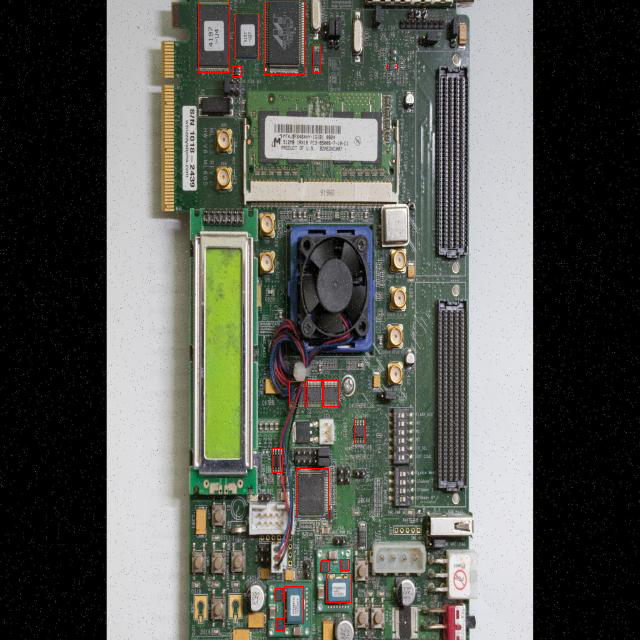

In [96]:
draw = ImageDraw.Draw(vsample)
for box in boxes:
    draw.rectangle(list(box),fill = None, outline = "red")
vsample